## Methods & Results:
- describe the methods you used to perform your analysis from beginning to end that narrates the analysis code.
your report should include code which:
- loads data 
- wrangles and cleans the data to the format necessary for the planned analysis
- performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
- creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
performs the data analysis
- creates a visualization of the analysis 
- note: all figures should have a figure number and a legend

## Methods and Plan
To address the question, we will follow the standard steps of a classification problem. This method is appropriate because we are using two quantitative variables to predict a categorical variable. A potential weakness for using age and played hours to predict subscription is that, since played hours and age does not have a clear relationship and most players have near-zero hours, using nearest neighbor may not perform the best compared to other methods. To determine how well `played_hours` and `Age` can predict `subscribe` in `players`, we can build the best model by these steps:
1. Make a recipe by setting `played_hours` and `Age` as the predictor and `subscribe` as the classifier.
2. Add the knn engine, nearest neighbor, and "classification" to the model specification.
3. Randomize and split the data into 80% training set and 20% test set
4. Fit the model and recipe to the training set
5. Perform the cross validation on different K neighbors (1~100, step=5). Cross validation with 10 folds on the training set, with each fold containing a different 10% of the validation set. 
6. Choose the K that has the highest accuracy in predicting `subscribe`
 
Then, use this model to predict `subscribe` in the test set and determine the accuracy.

## 1. Load and Wrangle Data

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)

options(repr.matrix.max.rows = 6)
url <- "https://raw.githubusercontent.com/carinahuang68/toy_ds_project/refs/heads/main/players.csv"
players <- read_csv(url)
players_tidy <- players |>
    select(Age, played_hours,subscribe )|>
    drop_na() |>
    mutate(subscribe = as_factor(subscribe))|>
    mutate(Age = as.integer(Age))
players_tidy

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Age played_hours subscribe
1    9  30.3         TRUE     
2   17   3.8         TRUE     
3   17   0.0         FALSE    
⋮   ⋮   ⋮            ⋮        
192 22  0.3          FALSE    
193 17  0.0          FALSE    
194 17  2.3          FALSE

## 2. Splitting Data:



In [2]:
players_split <- initial_split(players_tidy, prop = 0.8, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)
players_train
players_test

Age played_hours subscribe
1   17  0            FALSE    
2   21  0            FALSE    
3   22  0            FALSE    
⋮   ⋮   ⋮            ⋮        
152 22  32           TRUE     
153 17   0           TRUE     
154 20   0           TRUE

Age played_hours subscribe
1   9  30.3         TRUE     
2  17   0.1         TRUE     
3  22   0.0         TRUE     
⋮  ⋮   ⋮            ⋮        
38 17  0            TRUE     
39 17  0            FALSE    
40 17  0            TRUE

## 3. Summary of Data Set (training)

In [3]:
summary(players_train)

      Age         played_hours     subscribe  
 Min.   : 8.00   Min.   :  0.000   FALSE: 41  
 1st Qu.:17.00   1st Qu.:  0.000   TRUE :113  
 Median :20.00   Median :  0.100              
 Mean   :20.61   Mean   :  6.625              
 3rd Qu.:22.00   3rd Qu.:  0.600              
 Max.   :50.00   Max.   :223.100              



### Number of rows = 154.
  
  So there are 154 observations. Each observation represents a single player. 

### Number of columns = 3.

  There are three variables that represents the players:
1. `subscribe`: subscription status (type = fct)
2. `played_hours`: hours played in game in hours (type = double)
3. `age`: age of player (type = int)

### Summary statistics:

#### `subscribe` 
- Out of the 154 players, a total of 113 players were subscribed
#### `played_hours` 
- mean: 6.312
- max: 223.1
- min: 0
- median = 0.1
#### `Age` 
- mean: 20.69
- max: 50 
- min: 9
- median = 19


#### Potential issues:
- Many players have zero played hours, creating a skewed, unbalanced dataset. These players may not represent typical gameplay, reducing the predictive power of played_hours.

## 3. Visualization of Data

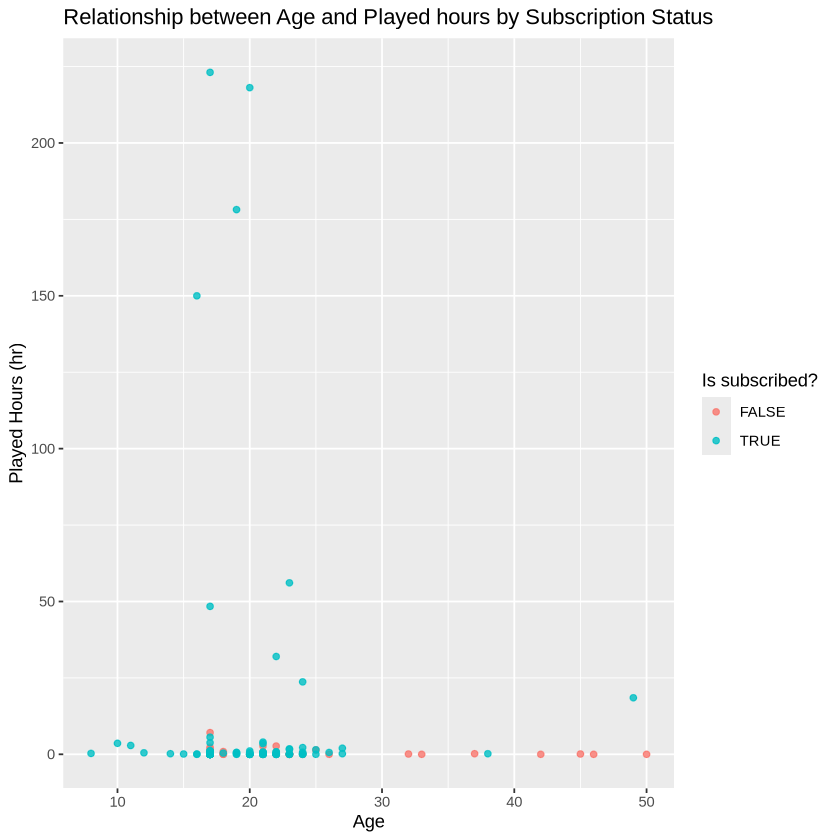

In [4]:
# dot plot for age, played_hours, and subscribe
players_dotplot <- ggplot(players_train, aes(x = Age, y = played_hours, colour = subscribe)) +
    geom_point(alpha = 0.8) +
    labs(x = "Age", y = "Played Hours (hr)", colour = "Is subscribed?") +
    ggtitle("Relationship between Age and Played hours by Subscription Status")
players_dotplot

In the dot plot, I noticed that players who exceed a certain playtime always subscribe, making the nearest neighbor predict subscription for high-playtime users. Additionally, all players under 17 subscribe, but these groups are too small to generalize well. Predicting subscription for older players (17-50) with little playtime is difficult, as their status appears random. Similarly, players over 30 mostly have near-zero hours, making played hours a weak predictor for them in the nearest neighbor model. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


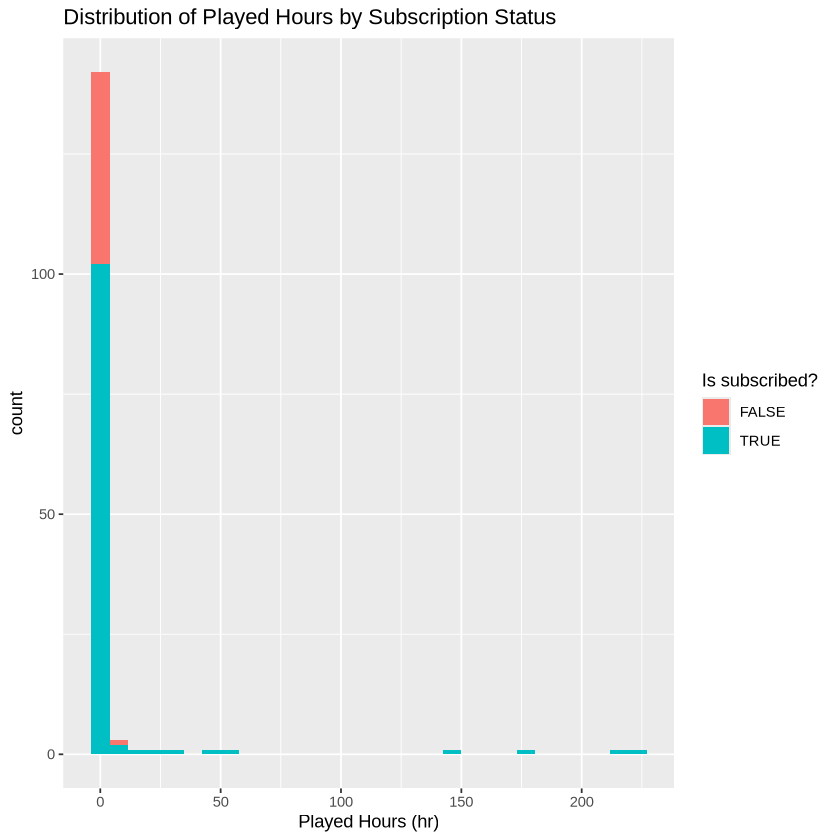

In [5]:
# histogram for playered hours (fill: subscribe)
players_played_hours_plot <- ggplot(players_train, aes(x = played_hours, fill = subscribe)) +
    geom_histogram() + 
    labs(x = "Played Hours (hr)", fill = "Is subscribed?") +
    ggtitle("Distribution of Played Hours by Subscription Status")
players_played_hours_plot

The histogram for played hours confirms that the majority of players have near-zero played hours.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


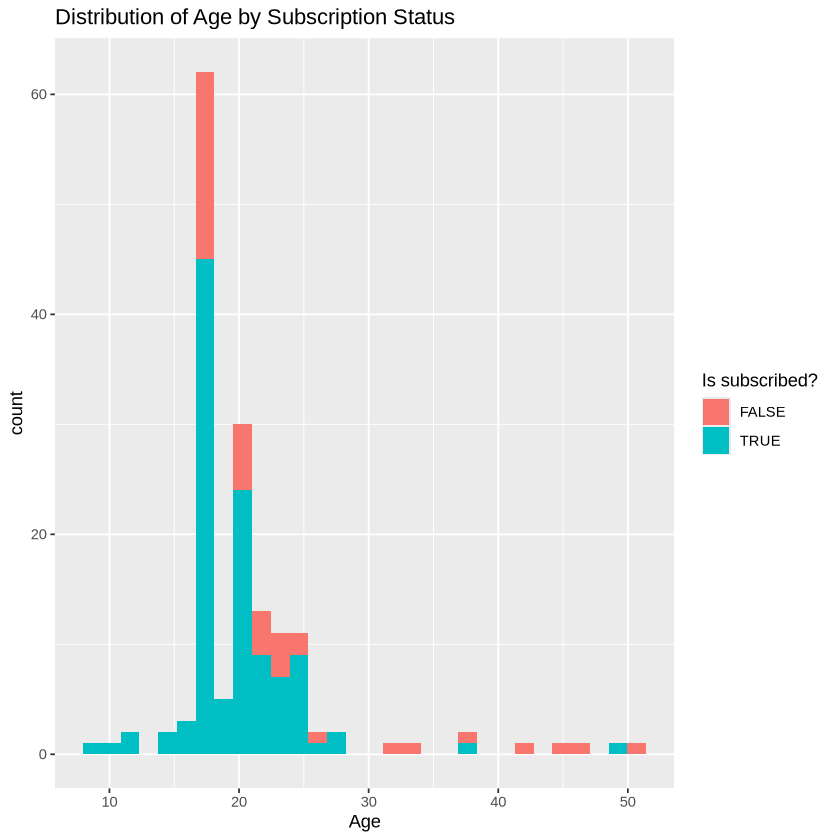

In [6]:
# histogram for age (fill: subscribe)
players_age_plot <- ggplot(players_train, aes(x = Age, fill = subscribe)) +
    geom_histogram() + 
    labs(x = "Age", fill = "Is subscribed?") +
    ggtitle("Distribution of Age by Subscription Status")
players_age_plot

The histogram for age shows that most players are aged 15 to 25 years old, with 17 years old being the majority. 

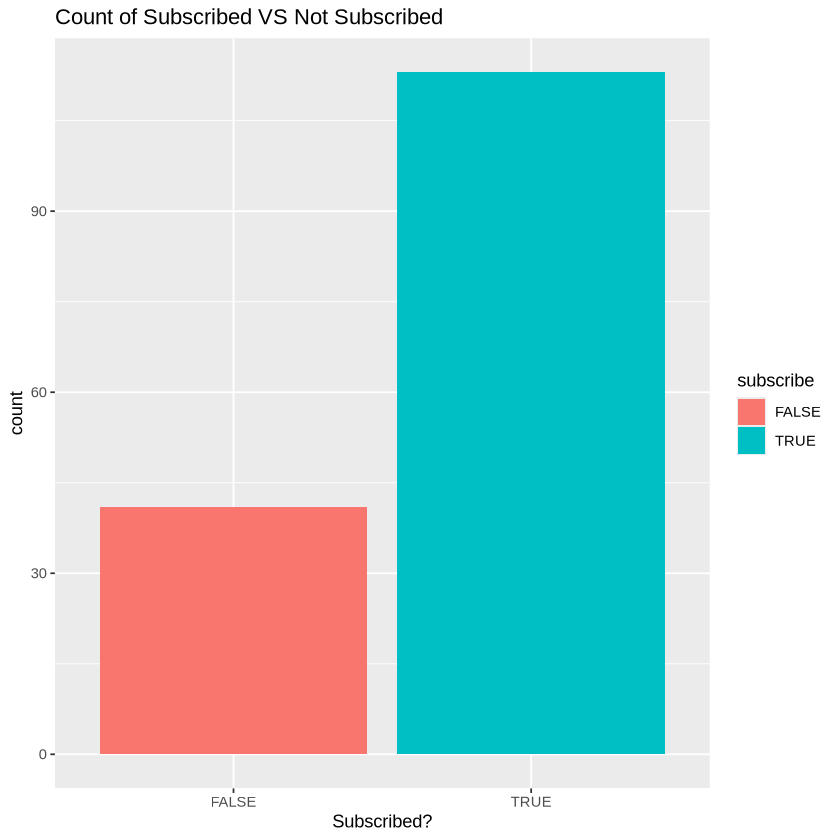

In [7]:
# bar plot for subscribed
players_subscribe <- ggplot(players_train, aes(x = subscribe, fill = subscribe)) +
    geom_bar(stat = "count") +
    xlab("Subscribed?") +
    ggtitle("Count of Subscribed VS Not Subscribed")
players_subscribe

The bar plot shows that most players are subscribed.

## 4. Data Analysis

In [8]:
set.seed(1234)


players_recipe <- recipe(subscribe~ Age + played_hours, data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
    set_engine("kknn")|>
    set_mode("classification")
knn_tune

players_vfold <- vfold_cv(players_train, v=10, strata = subscribe)

k_vals <- tibble(neighbors= seq(from = 1, to = 30, by = 1))

knn_results <- workflow() |>
    add_recipe(players_recipe)|>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold, grid = k_vals)|>
    collect_metrics()
knn_results



K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


neighbors .metric  .estimator mean      n  std_err     .config              
1  1         accuracy binary     0.5513725 10 0.03747306  Preprocessor1_Model01
2  1         roc_auc  binary     0.5538636 10 0.05141534  Preprocessor1_Model01
3  2         accuracy binary     0.5521569 10 0.03230929  Preprocessor1_Model02
⋮  ⋮         ⋮        ⋮          ⋮         ⋮  ⋮           ⋮                    
58 29        roc_auc  binary     0.5671212 10 0.044927111 Preprocessor1_Model29
59 30        accuracy binary     0.7339216 10 0.003808837 Preprocessor1_Model30
60 30        roc_auc  binary     0.5753977 10 0.045656315 Preprocessor1_Model30

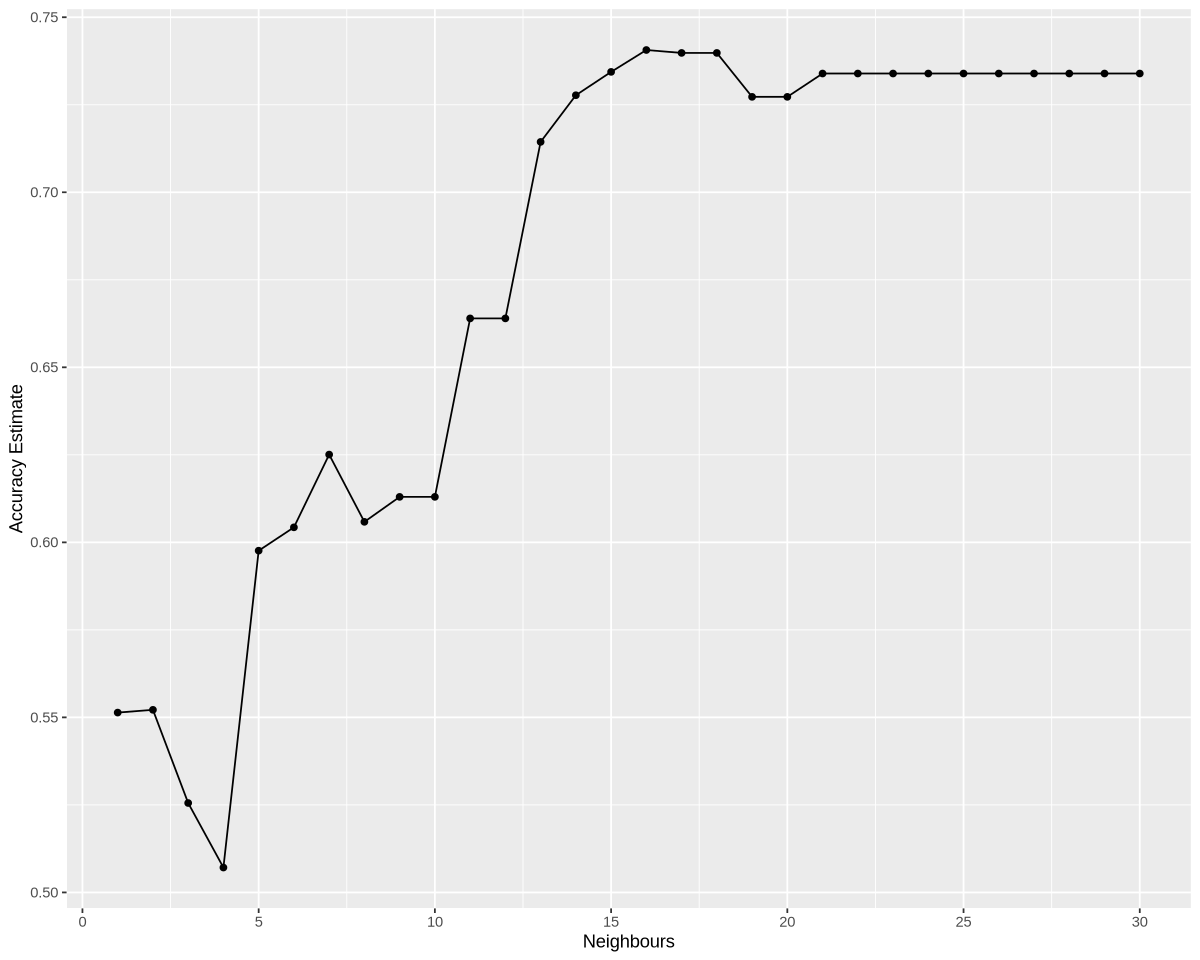

In [9]:

accuracies <- knn_results |>
    filter(.metric == "accuracy")

options(repr.plot.width = 10, repr.plot.height = 8)
accplot <- ggplot(accuracies, aes(x=neighbors, y=mean))+
    geom_point()+
    geom_line()+
    labs(x="Neighbours", y="Accuracy Estimate" )+
    scale_x_continuous(breaks = seq(0,100, by = 5))
accplot



In [10]:
set.seed(4231)
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

[1] 16

From the plot above, we can see that the acurracy is the highest at K = 13. We also sorted the data by accuracy and used the head function to confirm that the best K is 13. Therefore, we will choose k = 13.

### Building the Model

In [11]:
set.seed(1231)
knn_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) |>
    set_engine("kknn")|>
    set_mode("classification")
knn_model

knn_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_model) |>
    fit(data = players_train)
knn_fit

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 13
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(13,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2402597
Best kernel: rectangular
Best k: 13

### Predictions

In [12]:
players_subscription_predictions <- predict(knn_fit, players_test) |>
    bind_cols(players_test)
players_subscription_predictions

prediction_accuracy <- players_subscription_predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")
prediction_accuracy

prediction_presision <- players_subscription_predictions |>
    precision(truth = subscribe, estimate = .pred_class)
prediction_presision

prediction_recall <- players_subscription_predictions |>
    recall(truth = subscribe, estimate = .pred_class, event_level = "first")
prediction_recall

confusion <- players_subscription_predictions|>
    conf_mat(truth = subscribe, estimate = .pred_class)
confusion

.pred_class Age played_hours subscribe
1  TRUE         9  30.3         TRUE     
2  TRUE        17   0.1         TRUE     
3  TRUE        22   0.0         TRUE     
⋮  ⋮           ⋮   ⋮            ⋮        
38 TRUE        17  0            TRUE     
39 TRUE        17  0            FALSE    
40 TRUE        17  0            TRUE

.metric  .estimator .estimate
1 accuracy binary     0.675

.metric   .estimator .estimate
1 precision binary     0

.metric .estimator .estimate
1 recall  binary     0

          Truth
Prediction FALSE TRUE
     FALSE     0    2
     TRUE     11   27

### Visualization of Analysis

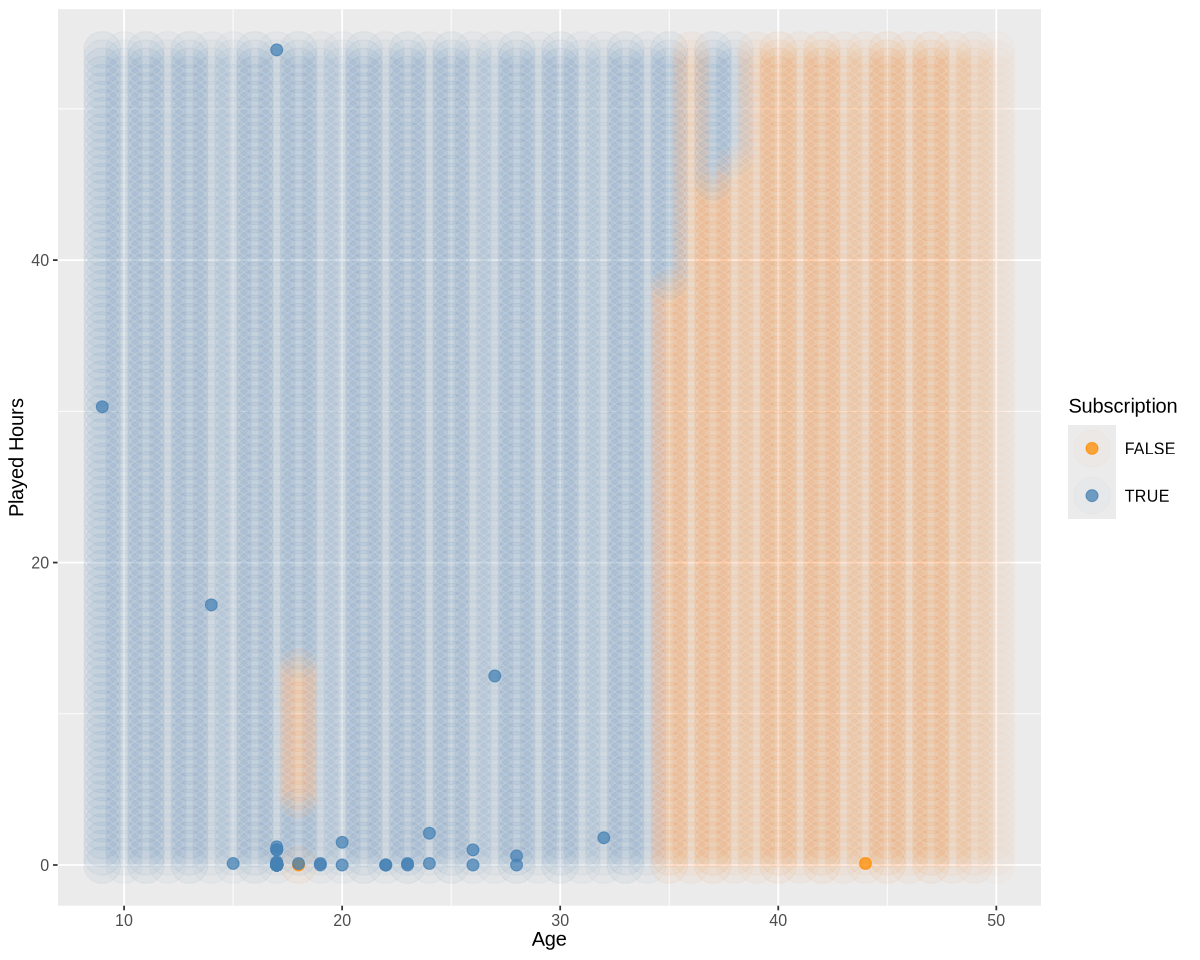

In [13]:
# plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid points

age_grid <- seq(min(players_test$Age),
               50,
                length.out = 100)
playedhours_grid <- seq(min(players_test$played_hours),
                max(players_test$played_hours),
                length.out = 100)

asgrid <- as_tibble(expand.grid(Age = age_grid,
                                played_hours = playedhours_grid)) |>
    mutate(Age = as.integer(Age))

knnPredGrid <- predict(knn_fit, asgrid)

prediction_table <- bind_cols(knnPredGrid, asgrid)|>
    rename(Class = .pred_class)

wkflw_plot <-
  ggplot() +
  geom_point(data = prediction_table,
             mapping = aes(x = Age,
                           y = played_hours,
                           color = Class),
             alpha = 0.02,
             size = 10) +
  geom_point(data = players_subscription_predictions,
             mapping = aes(x = Age,
                           y = played_hours,
                           color = .pred_class),
             alpha = 0.75,
            size = 3) +
  labs(color = "Subscription",
       x = "Age",
       y = "Played Hours") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))
    # ylim(c(0, 10))
wkflw_plot 